# Sysmon Failure and Performance Analysis (Latest Session)

This notebook extracts all Sysmon failures from the latest session file, summarizes performance for each failure, and identifies the key pressed by the user to resolve each event.

## Outline

1. Import Required Libraries

2. Load Latest Session File

3. Extract All Failure Events

4. Summarize Performance for Each Failure

5. Identify Key Pressed to Resolve Each Failure

6. Visualize Results

In [1]:
# 1. Import Required Libraries

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import os

In [2]:
# 2. Load Latest Session File

latest_file = 'sessions/2025-07-20/137_250720_101756.csv'

df = pd.read_csv(latest_file, header=None)

df.columns = ['timestamp', 'scenario_time', 'event_type', 'plugin', 'param1', 'param2']

print(f"Loaded {len(df)} rows from {latest_file}")

Loaded 72316 rows from sessions/2025-07-20/137_250720_101756.csv


In [3]:
# 3. Extract All Failure Events

sysmon_failures = df[(df['plugin'] == 'sysmon') & (df['event_type'] == 'performance') & (df['param1'].str.contains('name'))]

print(f"Total Sysmon failures detected: {len(sysmon_failures)}")

display(sysmon_failures.head())

Total Sysmon failures detected: 6


,timestamp,scenario_time,event_type,plugin,param1,param2
20025,23.601073,19.272392,performance,sysmon,name,F1
25848,29.325657,24.997941,performance,sysmon,name,F5
46906,85.416278,75.333789,performance,sysmon,name,F6
47420,85.909189,75.812879,performance,sysmon,name,F2
48513,86.967492,76.872031,performance,sysmon,name,F2


In [4]:
# 4. Summarize Performance and Key Presses for Each Failure

failures = sysmon_failures[['timestamp', 'scenario_time', 'param2']].copy()

failures.rename(columns={'param2': 'gauge'}, inplace=True)


# For each failure, get signal_detection, response_time, and key pressed

results = []

for idx, row in failures.iterrows():

    ts = row['timestamp']

    sc = row['scenario_time']

    gauge = row['gauge']

    # Find signal_detection and response_time events with same timestamp/scenario_time

    signal_row = df[(df['plugin'] == 'sysmon') & (df['event_type'] == 'performance') & (df['param1'] == 'signal_detection') & (df['timestamp'] == ts) & (df['scenario_time'] == sc)]

    rt_row = df[(df['plugin'] == 'sysmon') & (df['event_type'] == 'performance') & (df['param1'] == 'response_time') & (df['timestamp'] == ts) & (df['scenario_time'] == sc)]

    key_row = df[(df['plugin'] == 'sysmon') & (df['event_type'] == 'performance') & (df['param1'] == 'key_pressed') & (df['timestamp'] == ts) & (df['scenario_time'] == sc)]

    signal = signal_row['param2'].values[0] if not signal_row.empty else None

    rt = rt_row['param2'].values[0] if not rt_row.empty else None

    key = key_row['param2'].values[0] if not key_row.empty else None

    results.append({'timestamp': ts, 'scenario_time': sc, 'gauge': gauge, 'signal_detection': signal, 'response_time': rt, 'key_pressed': key})


perf_df = pd.DataFrame(results)

print('Performance summary for each failure:')

display(perf_df)

Performance summary for each failure:


,timestamp,scenario_time,gauge,signal_detection,response_time,key_pressed
0,23.601073,19.272392,F1,None,None,None
1,29.325657,24.997941,F5,None,None,None
2,85.416278,75.333789,F6,None,None,None
3,85.909189,75.812879,F2,None,None,None
4,86.967492,76.872031,F2,None,None,None
5,88.82076,78.72542,F3,None,None,None


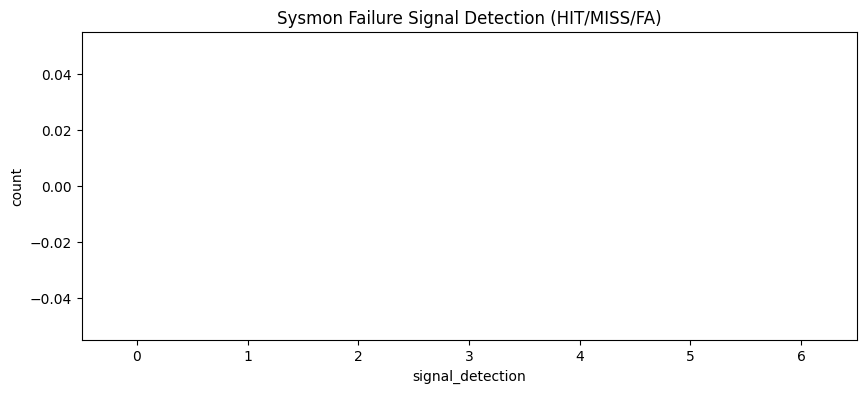

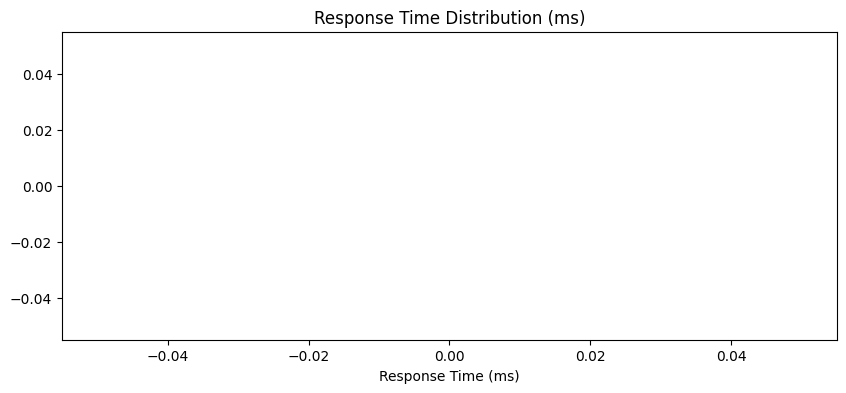

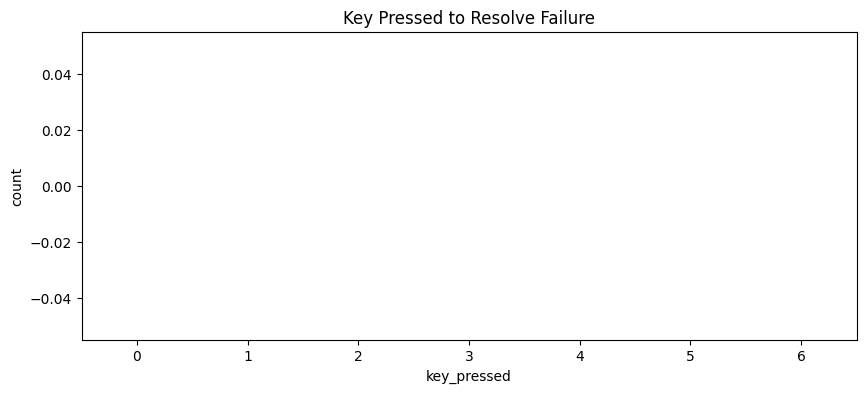

In [5]:
# 5. Visualize Results

if not perf_df.empty:

    plt.figure(figsize=(10, 4))

    sns.countplot(x='signal_detection', data=perf_df)

    plt.title('Sysmon Failure Signal Detection (HIT/MISS/FA)')

    plt.show()

    plt.figure(figsize=(10, 4))

    sns.histplot(pd.to_numeric(perf_df['response_time'], errors='coerce').dropna(), bins=30)

    plt.title('Response Time Distribution (ms)')

    plt.xlabel('Response Time (ms)')

    plt.show()

    plt.figure(figsize=(10, 4))

    sns.countplot(x='key_pressed', data=perf_df)

    plt.title('Key Pressed to Resolve Failure')

    plt.show()